In [1]:
import h5py
import numpy as np
import xarray as xr
from scipy import interpolate
import matplotlib.pyplot as plt

import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from osgeo import osr
from scipy import interpolate

# Utility functions

In [2]:
# Calculate distance along track
def calc_dat(ds_ATL11):
    distance = np.sqrt((ds_ATL11['x'][-1] - ds_ATL11['x'][0])**2 + (ds_ATL11['y'][-1] - ds_ATL11['y'][0])**2)
    dat = np.linspace(0, distance, len(ds_ATL11['x']))
    dat = dat / 1000
    return dat

# 1 km interpolation. First interpolate to 10 m, then 1 km
# x_src is distance along track at 1 km resolution. 
def interpolate_1km(x_src, y_src):
    
    # Linear interpolation to 10 m
    f = interpolate.interp1d(x_src, y_src, kind='linear')
    x_tgt  = np.arange(0, x_src[-1], 0.01)
    y_tgt = f(x_tgt)
    
    # Transform data from 10 m to 1 km using a convulution of the nearest 100 data points
    n_kernal = 100
    x_tgt  = np.convolve(x_tgt, np.ones(n_kernal)/n_kernal, mode='valid')[::n_kernal]
    y_tgt = np.convolve(y_tgt, np.ones(n_kernal)/n_kernal, mode='valid')[::n_kernal]
    
    return x_tgt, y_tgt

# Open ATL11 File

In [3]:
src_path = "/scratch/summit/erke2265/surface-height-change/data/pt1_ATL11_042310_0309_003_01.nc"
ds_ATL11 = xr.open_dataset(src_path)
ds_ATL11

<xarray.Dataset>
Dimensions:                  (cycle: 7, x: 13177, y: 13177)
Coordinates:
  * y                        (y) float64 -1.698e+03 -1.71e+03 ... -9.622e+04
  * cycle                    (cycle) int64 1 2 3 4 5 6 7
  * x                        (x) float64 -1.969e+06 -1.968e+06 ... -1.194e+06
Data variables:
    Height                   (y, cycle) float32 ...
    Height_Sigma             (y, cycle) float32 ...
    Height_Sigma_Systematic  (y, cycle) float32 ...
    Time                     (y, cycle) float64 ...

# Resample to 1 km

In [4]:
dat = calc_dat(ds_ATL11)
dat_1km, x_1km = interpolate_1km(dat, ds_ATL11['x'].values)
dat_1km, y_1km = interpolate_1km(dat, ds_ATL11['y'].values)

In [5]:
y_1km[1]

-1895.436711768948

# Get X/Y in lat/lon

In [6]:
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(3031) # WGS-84
tgt.ImportFromEPSG(4326) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
tgt_lon = np.zeros(len(x_1km)); tgt_lon[:] = np.nan
tgt_lat = np.zeros(len(x_1km)); tgt_lat[:] = np.nan

# Perform transformation
for j in range(0, len(x_1km)):
    coords = transform.TransformPoint(x_1km[j], y_1km[j])
    tgt_lat[j], tgt_lon[j] = coords[0:2]

In [7]:
# Compile into array and save
lat_lon = np.transpose(np.stack([tgt_lat, tgt_lon]))
print(lat_lon.shape)

# Save array
np.savetxt("IC2_lat_lon.txt", lat_lon)

(780, 2)


# Plot track

Text(0, 0.5, '[% of MERRA-2]')

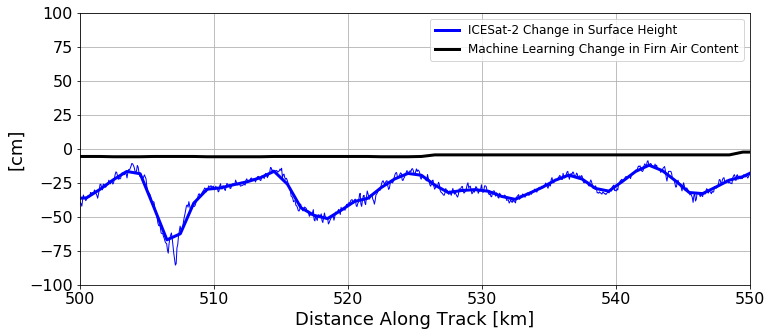

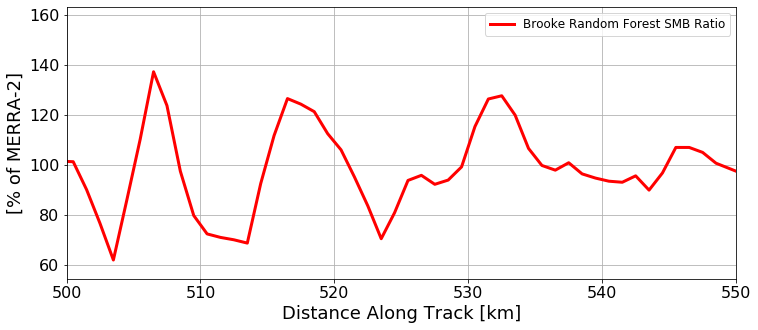

In [8]:
# IC2
dh = ds_ATL11['Height'][:,3] - ds_ATL11['Height'][:,2]
dh = dh * 100
dh_1km = interpolate_1km(dat, dh)[1]

# ML
ML_FAC = np.loadtxt("Inference_Y.txt")
RF_SMB_ratio = np.loadtxt("inference.txt")[:,-1]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(dat, dh, c='b', linewidth=1)
plt.plot(dat_1km, dh_1km, c='b', linewidth=3, label='ICESat-2 Change in Surface Height')
plt.plot(dat_1km, ML_FAC, c='k', linewidth=3, label='Machine Learning Change in Firn Air Content')
plt.xlim([500, 550])
plt.ylim([-100, 100])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.legend(fontsize=12)
plt.xlabel("Distance Along Track [km]", fontsize=18)
plt.ylabel("[cm]", fontsize=18)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(dat_1km, 100*RF_SMB_ratio, c='r', linewidth=3, label='Brooke Random Forest SMB Ratio')
plt.xlim([500, 550])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.legend(fontsize=12)
plt.xlabel("Distance Along Track [km]", fontsize=18)
plt.ylabel("[% of MERRA-2]", fontsize=18)